# Modelling

## 1.0 Importing libraries and loading data

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
import time

In [2]:
X = pd.read_csv('/Users/chinmayasukumar/Documents/Springboard/Capstone #2/data/interim/X.csv')
y = pd.read_csv('/Users/chinmayasukumar/Documents/Springboard/Capstone #2/data/interim/y.csv')
X_train = np.array(pd.read_csv('/Users/chinmayasukumar/Documents/Springboard/Capstone #2/data/interim/X_train.csv'))
y_train = np.array(pd.read_csv('/Users/chinmayasukumar/Documents/Springboard/Capstone #2/data/interim/y_train.csv'))
X_test = np.array(pd.read_csv('/Users/chinmayasukumar/Documents/Springboard/Capstone #2/data/interim/X_test.csv'))
y_test = np.array(pd.read_csv('/Users/chinmayasukumar/Documents/Springboard/Capstone #2/data/interim/y_test.csv'))

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((639, 14), (639, 1), (275, 14), (275, 1))

In [4]:
y_train, y_test = y_train.reshape(y_train.shape[0],), y_test.reshape(y_test.shape[0],)

In [5]:
y_train.shape, y_test.shape

((639,), (275,))

In [6]:
np.random.seed(42)

## 2.0 Selecting a Model

#### Since a benchmark is required, a dummy variable is trained

### 2.1 Dummy Regressor

In [7]:
np.mean(cross_val_score(DummyRegressor(), X_train, y_train))

-0.01722274027986135

In [8]:
mae_scores = cross_val_score(DummyRegressor(), X_train, y_train, scoring='neg_mean_absolute_error')
np.abs(np.mean(mae_scores))

113.21135537972671

### 2.2 Linear Regressor

In [58]:
scores = cross_val_score(LinearRegression(),X_train, y_train)
np.mean(scores)

0.7951165830641578

In [12]:
mae_scores = cross_val_score(LinearRegression(), X_train, y_train, scoring='neg_mean_absolute_error')
np.mean(np.abs(mae_scores))

42.7760975114539

#### 2.2.0 Model Performance

In [91]:
t0 = time.time()

lr = LinearRegression()
lr.fit(X_train, y_train)

print('Gradient Boosting Regressor train set performance',lr.score(X_train, y_train))
print('Gradient Boosting Regressor test set performance',lr.score(X_test, y_test))

print('Time: ',time.time() - t0)

Gradient Boosting Regressor train set performance 0.8103445852247525
Gradient Boosting Regressor test set performance 0.8514814004968662
Time:  0.008359909057617188


The model is not over or underfitting since performance is similar in both training and testing sets

#### 2.2.1 Feature Importance

<BarContainer object of 14 artists>

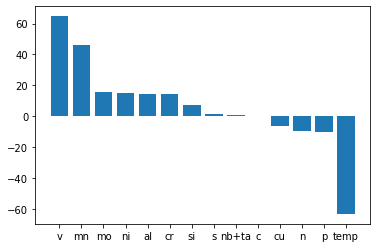

In [64]:
imp = pd.Series(lr.coef_, index=X.columns).sort_values(ascending=False)
plt.bar(imp.index, imp)

As it can be seen, Vanadium and temperature seem to be the values that are the most correlated with the steel strength. Vanadium contributes to strength whereas increases in temperature, understandably reduce strength

### 2.3 Lasso Regressor

In [52]:
lasso = Lasso()
lasso_mae = Lasso()

params={'alpha':[0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0]}

lasso_cv, lasso_cv_mae = GridSearchCV(lasso, params, cv=5), GridSearchCV(lasso_mae, params, cv=5, 
                                                                         scoring='neg_mean_absolute_error')
lasso_cv.fit(X_train, y_train)
lasso_cv_mae.fit(X_train, y_train)

print('R2: ',lasso_cv.best_params_, lasso_cv.best_score_,)
print('MAE: ', lasso_cv_mae.best_params_, lasso_cv_mae.best_score_)

R2:  {'alpha': 0.5} 0.7956069252376017
MAE:  {'alpha': 0.2} -42.7724132840526


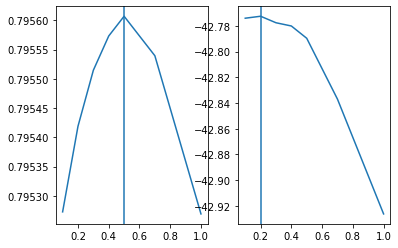

In [53]:
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0]
scores = []
mae_scores = []

for i in alpha:
    lasso = Lasso(i)
    lasso_mae = Lasso(i)
    scores.append(np.mean(cross_val_score(lasso,X_train, y_train)))
    mae_scores.append((np.mean(cross_val_score(lasso_mae, X_train, y_train, scoring='neg_mean_absolute_error'))))

fig, ax = plt.subplots(1,2)

ax[0].plot(alpha, scores)
ax[0].axvline(0.5)
ax[1].plot(alpha, mae_scores)
ax[1].axvline(0.2)

plt.show()

#### alpha = 0.5 results in highest accuracy but not by a large margin

#### 2.3.0 Model Performance

In [85]:
t0 = time.time()

lasso_model = Lasso(0.5)
lasso_model.fit(X_train, y_train)

print('Gradient Boosting Regressor train set performance',lasso_model.score(X_train, y_train))
print('Gradient Boosting Regressor test set performance',lasso_model.score(X_test, y_test))

print('Time: ',time.time() - t0)

Gradient Boosting Regressor train set performance 0.8101051594190554
Gradient Boosting Regressor test set performance 0.8512405058101677
Time:  0.019649028778076172


The model is not over or underfitting since performance is similar in both training and testing sets

### 2.4 Random Forest Regressor

#### This function will be useful in plotting feature importance of the following regressors

In [17]:
def importance_plotter(model):
    plt.subplots(figsize=(10, 5))
    imps = model.best_estimator_.feature_importances_
    feat_imps = pd.Series(imps, index=X.columns).sort_values(ascending=False)
    feat_imps.plot(kind='bar')
    plt.xlabel('features')
    plt.ylabel('importance')
    plt.title('Best random forest regressor feature importances');
    plt.show()

In [18]:
params = {'n_estimators':[5,10,20,30,40,50,60,70,80], 'criterion':['squared_error', 'absolute_error', 'poisson']}

rf = RandomForestRegressor()
rf_cv = GridSearchCV(rf, params, cv=5, n_jobs=-1)
rf_cv.fit(X_train, y_train)

print(rf_cv.best_params_, rf_cv.best_score_)
print(rf_cv.best_estimator_)

{'criterion': 'absolute_error', 'n_estimators': 80} 0.9327367752294811
RandomForestRegressor(criterion='absolute_error', n_estimators=80)


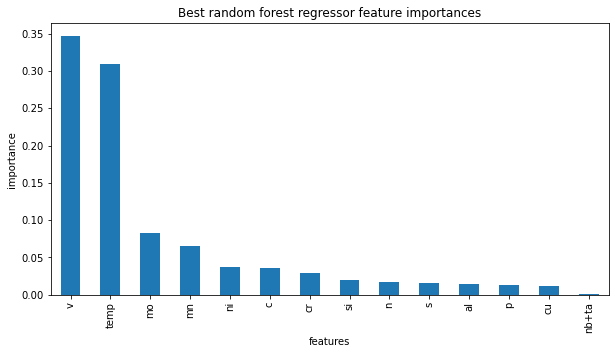

In [19]:
importance_plotter(rf_cv)

Vanadium and temperature once again are the biggest predictors of strenght

#### 2.4.0 Model Performance

In [87]:
t0 = time.time()

rf_model = RandomForestRegressor(criterion='absolute_error', n_estimators=80)
rf_model.fit(X_train, y_train)

print('Gradient Boosting Regressor train set performance',rf_model.score(X_train, y_train))
print('Random Forest Regressor test set performance', rf_model.score(X_test, y_test))

print('Time: ', time.time() - t0)

Gradient Boosting Regressor train set performance 0.9911438875679653
Random Forest Regressor test set performance 0.9713616338199894
Time:  1.6884880065917969


The model is not over or underfitting since performance is similar in both training and testing sets

### Gradient Boosting Regressor

In [20]:
params = {'loss':['squared_error', 'absolute_error'], 'learning_rate':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0], 
          'n_estimators': [5, 10, 15, 20, 25, 30]}

gb_cv = GridSearchCV(GradientBoostingRegressor(), params, cv=5)
gb_cv.fit(X_train, y_train)

print(gb_cv.best_params_, gb_cv.best_score_)

{'learning_rate': 0.5, 'loss': 'squared_error', 'n_estimators': 30} 0.921108812785333


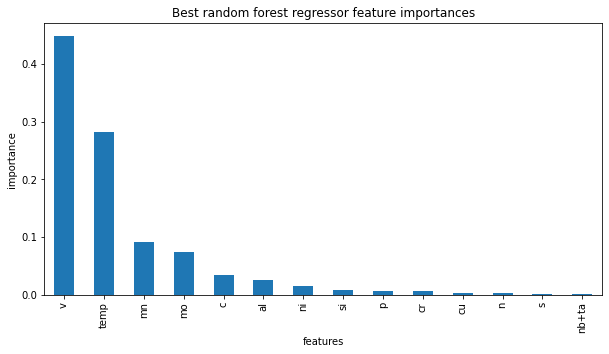

In [21]:
importance_plotter(gb_cv)

In [90]:
t0 = time.time()

gb_model = RandomForestRegressor(criterion='absolute_error', n_estimators=40)
gb_model.fit(X_train, y_train)

print('Gradient Boosting Regressor test set performance',gb_model.score(X_train, y_train))
print('Gradient Boosting Regressor test set performance',gb_model.score(X_test, y_test))

print('Time: ', time.time() - t0)

Gradient Boosting Regressor test set performance 0.9888578648405746
Gradient Boosting Regressor test set performance 0.9683024581446339
Time:  0.9537169933319092


The model is not over or underfitting since performance is similar in both training and testing sets

#### The linear regressor had an accuracy of 0.8515 and the lasso regressor was marginally less accurate on the tests sets. The Both the Random Forest model and the Gradient Boosting model had accuracies above 96% for both their training and testing sets however the the Gradient Boosting model was much faster. After considering these models, the Gradient Boosting Regressor will be chosen for it's accuracy and speed.